In [16]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from pingouin import rm_anova, pairwise_tukey, friedman, wilcoxon
from statsmodels.stats.anova import AnovaRM
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# from statannot import add_stat_annotation

In [17]:
dataset=pd.read_excel("Feature.xlsx")

In [18]:
# pair-wise wilcoxon test 
def pw_wilcoxon_test(set):
    emotion=np.arange(0, 4)
    emotion_cb=combinations(emotion, 2)
    poc_list=pd.DataFrame(columns=['A', 'B', 'W', 'p', 'RBC', 'CLES'])
    for ecb in emotion_cb:
        x_pw=set.loc[set['emotion']==ecb[0], 'feature']
        y_pw=set.loc[set['emotion']==ecb[1], 'feature']
        poc_list_emotion=wilcoxon(x_pw, y_pw)
        poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]], 
                                                    'W':[poc_list_emotion['W-val'].iloc[0]],
                                                    'p':[poc_list_emotion['p-val'].iloc[0]],
                                                    'RBC':[poc_list_emotion['RBC'].iloc[0]],
                                                    'CLES':[poc_list_emotion['CLES'].iloc[0]]})],
                                                    ignore_index=True)
    return poc_list

In [19]:
def difference(name):
    x=np.array(dataset[name]).reshape((192, 1))
    y=np.array(dataset.emotion).reshape((192, 1))
    # normalized
    sc=StandardScaler()
    x=sc.fit_transform(x)
    # kstest
    _, p_ks=stats.kstest(x, stats.norm.cdf)
    set=pd.DataFrame(np.concatenate((y,x), axis=1), columns=['emotion', 'feature'])
    set['subject']=dataset.subject
    # if gaussianity of data is true
    if p_ks>=0.05:
        # rm anova for feature in different emotion
        stats_list=rm_anova(data=set,dv='feature', within='emotion', subject='subject')
        # poc host test for rm anova
        poc_list=pairwise_tukey(data=set, dv='feature', between='emotion')
        # rm anova for subject variance
        stats_list_subject = rm_anova(data=set, dv='feature', within='subject', subject='emotion')
        
    else:
        # friedman test
        stats_list=friedman(data=set, dv='feature', within='emotion', subject='subject')
        # pair-wise poc host test for friedman test 
        poc_list=pw_wilcoxon_test(set)
        # friedman test for subject variance
        stats_list_subject = friedman(data=set, dv='feature', within='subject', subject='emotion')

    # visualization
    print('emotion:', stats_list["p-unc"].iloc[0], 'subject:', stats_list_subject["p-unc"].iloc[0])
    # KS test, emotion_wise, subject_wise, post hoc test
    return set, p_ks, stats_list, stats_list_subject, poc_list

In [20]:
def significant_plot(name):
    set, pks, stats_list, stats_list_subject, poc_list =difference(name)
    # significant combinations
    # boxplot
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 16
    plt.figure(figsize=(5, 5))
    gs=gridspec.GridSpec(1, 1)
    ax=plt.subplot(gs[0, 0])
    bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
    bottom, top = ax.get_ylim()
    y_range = top - bottom
    # significant bar
    # normal
    if pks>=0.05:
        # num_s->number of signigicant
        num_s=(poc_list['p-tukey']<=0.05).sum()
        p_title=stats_list.loc[0, 'p-unc']
        # print(level)
        j=0
        for i in range(6):
            if poc_list.loc[i, 'p-tukey']<=0.05:
                x1=poc_list.loc[i, 'A']
                x2=poc_list.loc[i, 'B']
                level=num_s-j
                bar_height = (y_range * 0.16 * level) + top-y_range * 0.15
                bar_tips = bar_height - (y_range * 0.03)
                plt.plot([x1, x1, x2, x2],[
                    bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
                p=poc_list.loc[i, 'p-tukey']
                if p < 0.001:
                    sig_symbol = '***'
                elif p < 0.01:
                    sig_symbol = '**'
                elif p < 0.05:
                    sig_symbol = '*'
                sig_symbol=sig_symbol+f'{ poc_list.loc[i, 'hedges']:.2f}'
                text_height = bar_height + (y_range * 0.001)
                plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
                j+=1

    # non-normal
    else:
        num_s=(poc_list['p']<=0.05).sum()
        p_title=stats_list.loc['Friedman', 'p-unc']
        # print(level)
        j=0
        for i in range(6):
            if poc_list.loc[i, 'p']<=0.05:
                x1=poc_list.loc[i, 'A']
                x2=poc_list.loc[i, 'B']
                level=num_s-j
                bar_height = (y_range * 0.16 * level)+top-y_range * 0.16
                bar_tips = bar_height - (y_range * 0.03)
                plt.plot([x1, x1, x2, x2],[
                    bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
                p=poc_list.loc[i, 'p']
                if p < 0.001:
                    sig_symbol = '***'
                elif p < 0.01:
                    sig_symbol = '**'
                elif p < 0.05:
                    sig_symbol = '*'
                sig_symbol=sig_symbol+f' { poc_list.loc[i, 'RBC']:.2f}'
                text_height = bar_height + (y_range * 0.001)
                plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
                j+=1

    x_labels = ['F', 'J', 'R', 'S']
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # set title
    sig_symbol=''
    if p_title < 0.001:
        sig_symbol = '***'
    elif p_title < 0.01:
        sig_symbol = '**'
    elif p_title < 0.05:
        sig_symbol = '*'
    sig_symbol=name+" "+sig_symbol
    ax.set_title(sig_symbol)
    # ax.set_yticks([])
    ax.set_ylim([bottom, (y_range * 0.16 * (num_s))+top])
    plt.show()
    return pks, bp, stats_list_subject, stats_list

emotion: 7.900461658679836e-05 subject: 0.013567956078295973


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

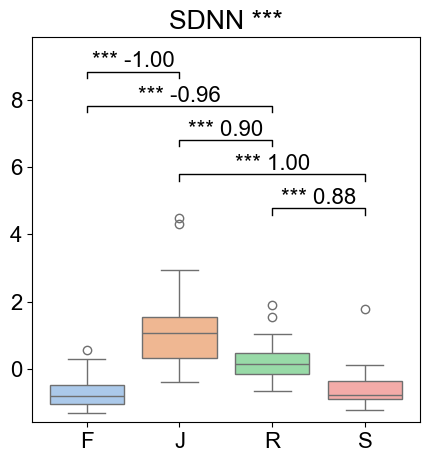

emotion: 5.9269748019426955e-05 subject: 0.11206743682500031


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

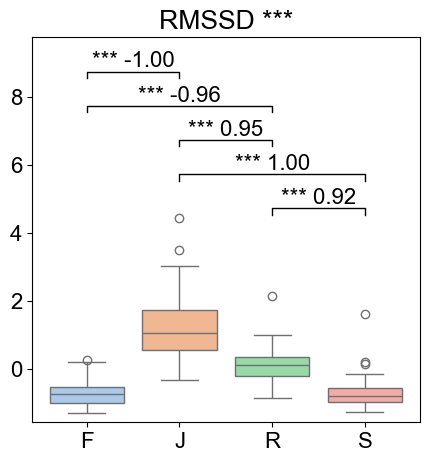

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')


emotion: 2.4523381374180087e-14 subject: 0.030803373771927555


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


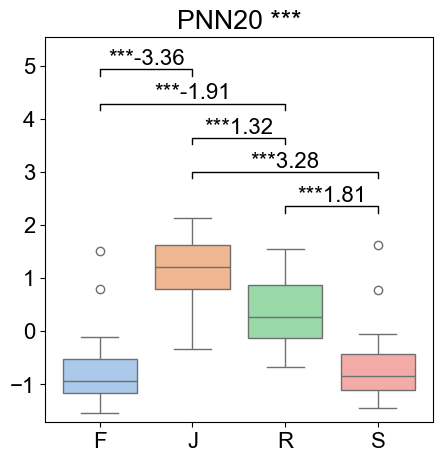

emotion: 1.160917363903015e-12 subject: 0.1369026103815175


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


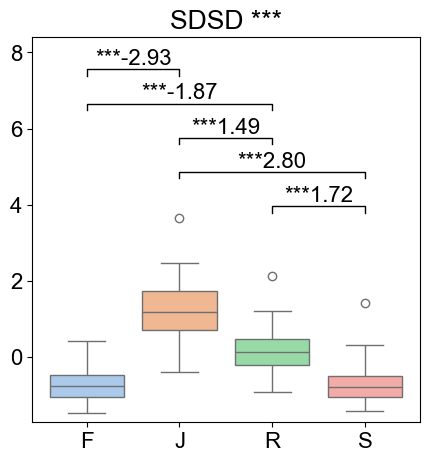

emotion: 1.5999244930016294e-06 subject: 0.6648027244895873


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


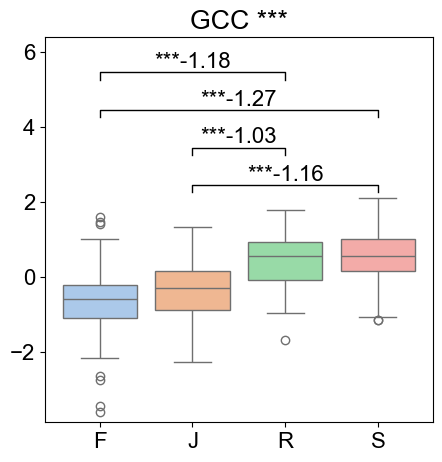

emotion: 2.9945177229128626e-09 subject: 0.8453553613194246


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


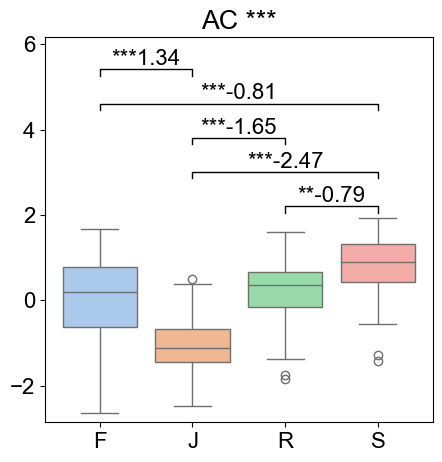

emotion: 0.00020086528269989783 subject: 0.6283831373845354


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


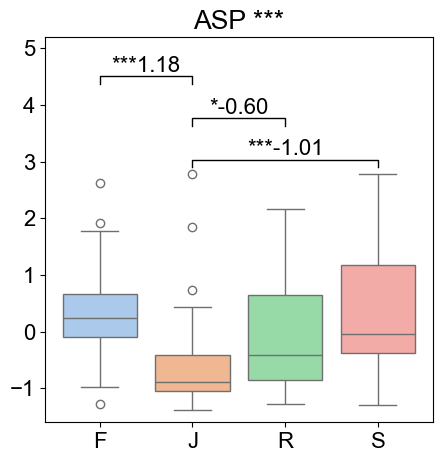

emotion: 0.029290886534888233 subject: 0.779777408475716


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

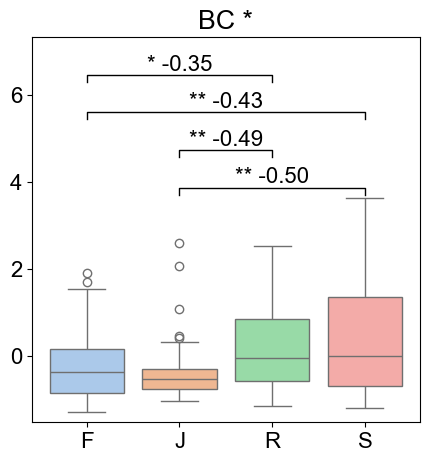

emotion: 1.1609173639030071e-12 subject: 0.13690261038151832


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


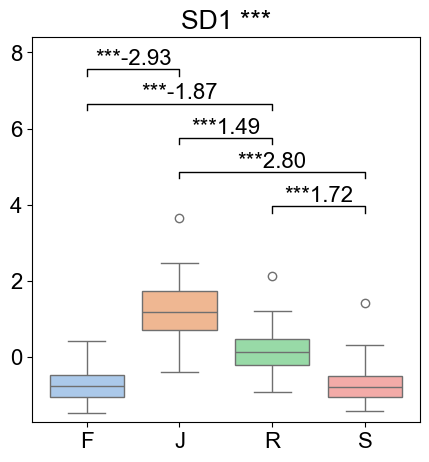

emotion: 7.900461658679836e-05 subject: 0.006135761298369721


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

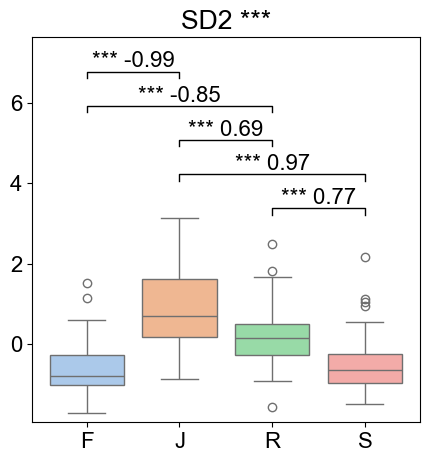

emotion: 2.0449044915261224e-09 subject: 0.010441156063210718


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


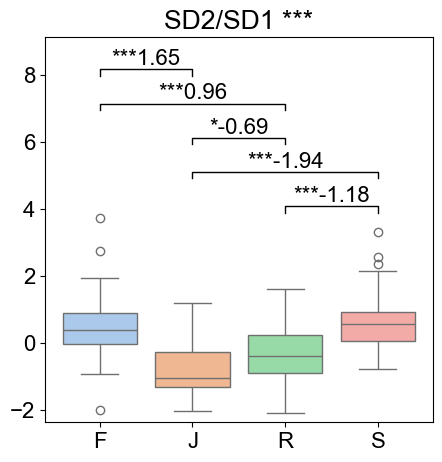

emotion: 0.033961593268979635 subject: 0.004592478898445351


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


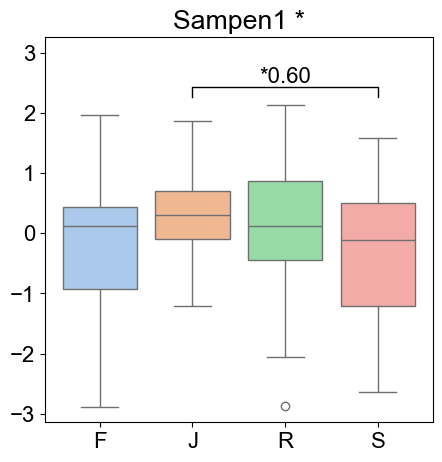

emotion: 0.02386926888236991 subject: 0.0405177046439214


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

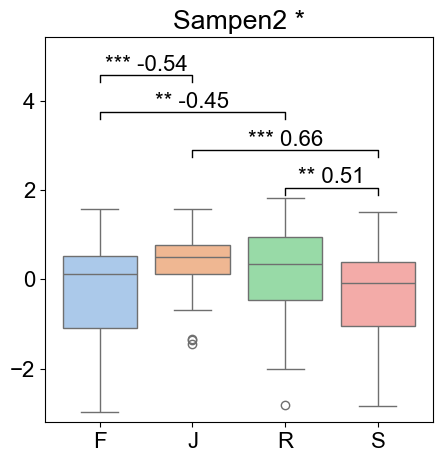

emotion: 0.5216582056420778 subject: 2.0985023187275162e-06


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


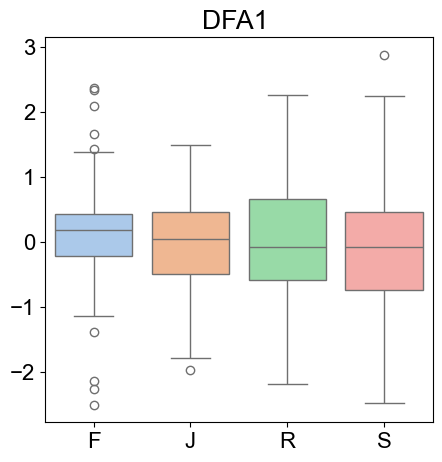

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1848689446.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poc_list=pd.concat([poc_list, pd.DataFrame({'A':[ecb[0]],'B':[ecb[1]],
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(set,y='feature',x='emotion', ax=ax,palette='pastel')
/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/1267597425.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

emotion: 0.018145863797500036 subject: 0.08065866508254801


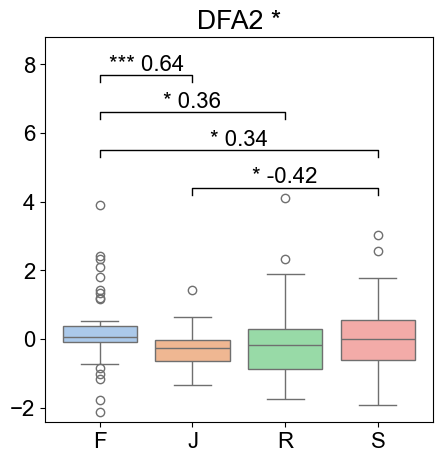

In [21]:
Features=['SDNN', 'RMSSD', 'PNN20', 'SDSD', 'GCC', 
          'AC','ASP', 'BC', 'SD1', 'SD2', 'SD2/SD1', 
          'Sampen1', 'Sampen2', 'DFA1', 'DFA2']
plot_list=[]
pks_list=[]
subject_list=[]
emotion_list=[]
for name in Features:
    pks, plot, subject, emotion=significant_plot(name)
    pks_list.append(pks)
    plot_list.append(plot)
    subject_list.append(subject)
    emotion_list.append(emotion)
    if name=='SD2/SD1':
        plot.get_figure().savefig('SD2_SD1_significant.svg')
    else:
        plot.get_figure().savefig(name+'_significant.svg')

In [22]:
subject_p=pd.DataFrame(columns=['feature', 'p'])
subject_p['feature']=Features
for i in range(len(Features)):
    df=subject_list[i]
    if pks_list[i]>=0.05:
        subject_p.loc[i, 'p']=df.loc[0, 'p-unc']
    else:
        subject_p.loc[i, 'p']=df.loc['Friedman', 'p-unc']

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/556390696.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha="right")


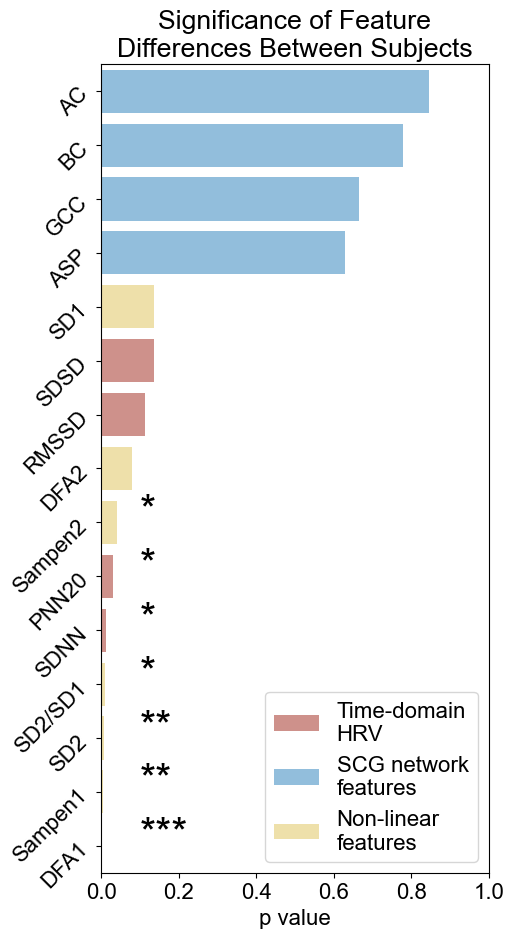

In [23]:
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(5, 10.5))
gs=gridspec.GridSpec(1, 1)
ax=plt.subplot(gs[0,0])
hue_order = ["Time-domain\nHRV", "SCG network\nfeatures", "Non-linear\nfeatures"]
category_labels = ['Time-domain\nHRV', 'SCG network\nfeatures', 'Non-linear\nfeatures']
custom_palette = ['#D98880', '#85C1E9', '#F9E79F']
subject_p['kind']=np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
subject_p['kind'] = subject_p['kind'].map({0: "Time-domain\nHRV", 1: "SCG network\nfeatures", 2: "Non-linear\nfeatures"})
ax.set_title('Significance of Feature\nDifferences Between Subjects')
subject_p_sort=subject_p.sort_values('p', axis=0, ascending=False)
sv_plot = sns.barplot(data=subject_p_sort, x='p', y='feature', hue='kind',palette=custom_palette,hue_order=hue_order,ax=ax)
ax.set_ylabel('')
ax.set_xlabel('p value')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha="right")
# add significant star
for i in range(len(Features)):
    p=subject_p.loc[i, 'p']
    if p<0.05:
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        plt.text(0.1, subject_p.loc[i, 'feature'], sig_symbol,fontsize=30)
ax.set_xlim([0, 1])
ax.legend(title='')
sv_plot.get_figure().savefig('subject_sagnificant.svg')


/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_83631/4260374809.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


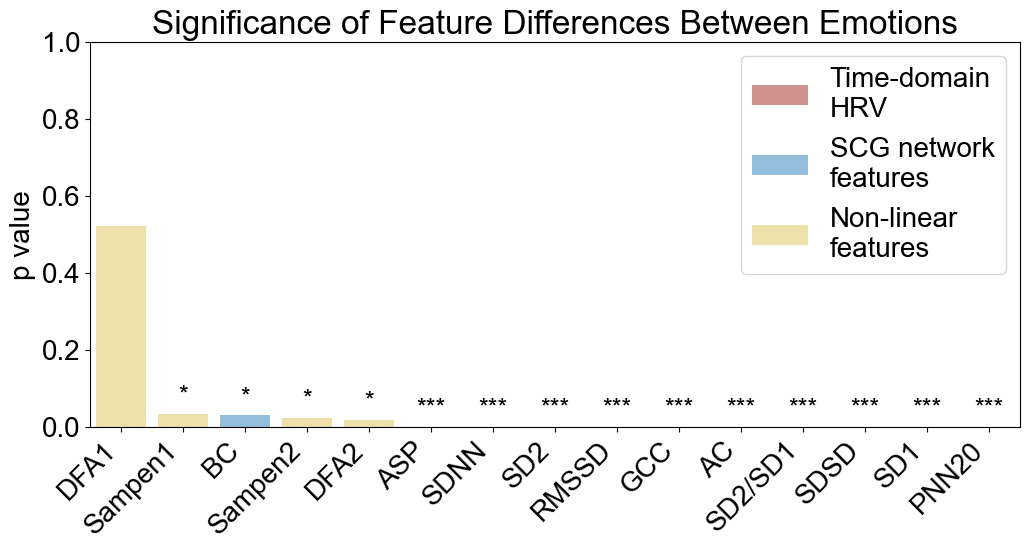

In [24]:
emotion_p=pd.DataFrame(columns=['feature', 'p'])
emotion_p['feature']=Features
for i in range(len(Features)):
    df=emotion_list[i]
    if pks_list[i]>=0.05:
        emotion_p.loc[i, 'p']=df.loc[0, 'p-unc']
    else:
        emotion_p.loc[i, 'p']=df.loc['Friedman', 'p-unc']
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 20
plt.figure(figsize=(12, 5))
gs=gridspec.GridSpec(1, 1)
ax=plt.subplot(gs[0,0])
hue_order = ["Time-domain\nHRV", "SCG network\nfeatures", "Non-linear\nfeatures"]
category_labels = ['Time-domain\nHRV', 'SCG network\nfeatures', 'Non-linear\nfeatures']
custom_palette = ['#D98880', '#85C1E9', '#F9E79F']
emotion_p['kind']=np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
emotion_p['kind'] = emotion_p['kind'].map({0: "Time-domain\nHRV", 1: "SCG network\nfeatures", 2: "Non-linear\nfeatures"})
ax.set_title('Significance of Feature Differences Between Emotions')
emotion_p_sort=emotion_p.sort_values('p', axis=0, ascending=False)

sv_plot = sns.barplot(
    data=emotion_p_sort,
    x='feature',
    y='p',
    hue='kind',
    palette=custom_palette,
    hue_order=hue_order,
    ax=ax
)

ax.set_xlabel('')
ax.set_ylabel('p value')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# 添加显著性星号（y方向）
for i, row in emotion_p_sort.iterrows():
    p = row['p']
    if p < 0.05:
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        else:
            sig_symbol = '*'
        x_pos = emotion_p_sort.index.get_loc(i)
        y_pos = row['p'] + 0.03  # 星号稍微高于条形
        plt.text(x_pos, y_pos, sig_symbol, ha='center', fontsize=18)

ax.set_ylim([0, 1])
ax.legend(title='')
sv_plot.get_figure().savefig('emotion_sagnificant.svg')
